<a href="https://colab.research.google.com/github/yandod/machine-learning-examples/blob/main/02_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 権利表示

## Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# はじめてのニューラルネットワーク：分類問題の初歩

このガイドでは、手書きの数字の画像を分類するニューラルネットワークのモデルをトレーニングします。すべての詳細を理解できなくても問題ありません。ここでは、完全な TensorFlow プログラムについて概説し、細かいところはその過程において見ていきます。

このガイドでは、TensorFlowのモデルを構築し訓練するためのハイレベルのAPIである [tf.keras](https://www.tensorflow.org/guide/keras)を使用します。

In [3]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.12.0


## MNIST データセットをインポートする

このガイドでは、MNISTデータセットを使用します。このデータセットには、10 カテゴリの 70,000 のグレースケール画像が含まれています。次のように、画像は低解像度（28 x 28 ピクセル）で個々の数字を示しています。

MNISTは、画像処理のための機械学習での"Hello, World"としてしばしば登場する[MNIST](http://yann.lecun.com/exdb/mnist/) データセットは手書きの数字（0, 1, 2 など）から構成されています。

ここでは、60,000 枚の画像を使用してネットワークをトレーニングし、10,000 枚の画像を使用して、ネットワークが画像の分類をどの程度正確に学習したかを評価します。

In [4]:
mnist = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


読み込んだデータセットは、NumPy 配列になります。

- `train_images` と `train_labels` の 2 つの配列は、モデルのトレーニングに使用される*トレーニング用データセット*です。
- モデルは、*テストセット*、`test_images`および`test_labels`  配列に対してテストされます。

画像は 28×28 の NumPy 配列から構成されています。それぞれのピクセルの値は 0 から 255 の間です。*ラベル*は、0 から 9 までの整数の配列です。

In [5]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

## データの観察

モデルのトレーニングを行う前に、データセットの形式を見てみましょう。下記のように、トレーニング用データセットには 28 × 28 ピクセルの画像が 60,000 含まれています。

In [6]:
train_images.shape

(60000, 28, 28)

同様に、トレーニング用データセットには 60,000 のラベルが含まれています。

In [7]:
len(train_labels)

60000

ラベルはそれぞれ、0 から 9 までの間の整数です。

In [8]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

テスト用データセットには、10,000 の画像が含まれます。画像は 28 × 28 ピクセルで構成されています。

In [9]:
test_images.shape

(10000, 28, 28)

テスト用データセットには 10,000 のラベルが含まれます。

In [10]:
len(test_labels)

10000

## ★データの前処理

ネットワークをトレーニングする前に、データを前処理する必要があります。最初の画像を調べてみればわかるように、ピクセルの値は 0 から 255 の間の数値です。

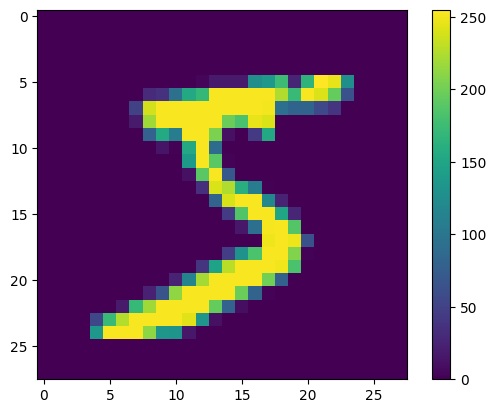

In [11]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

これらの値をニューラルネットワークモデルに供給する前に、0 から 1 の範囲にスケーリングします。これを行うには、値を 255 で割ります。*トレーニングセット*と*テストセット*を同じ方法で前処理することが重要です。

In [12]:
train_images = train_images / 255.0

test_images = test_images / 255.0

**訓練用データセット**の最初の25枚の画像を、クラス名付きで表示してみましょう。ネットワークを構築・訓練する前に、データが正しいフォーマットになっていることを確認します。

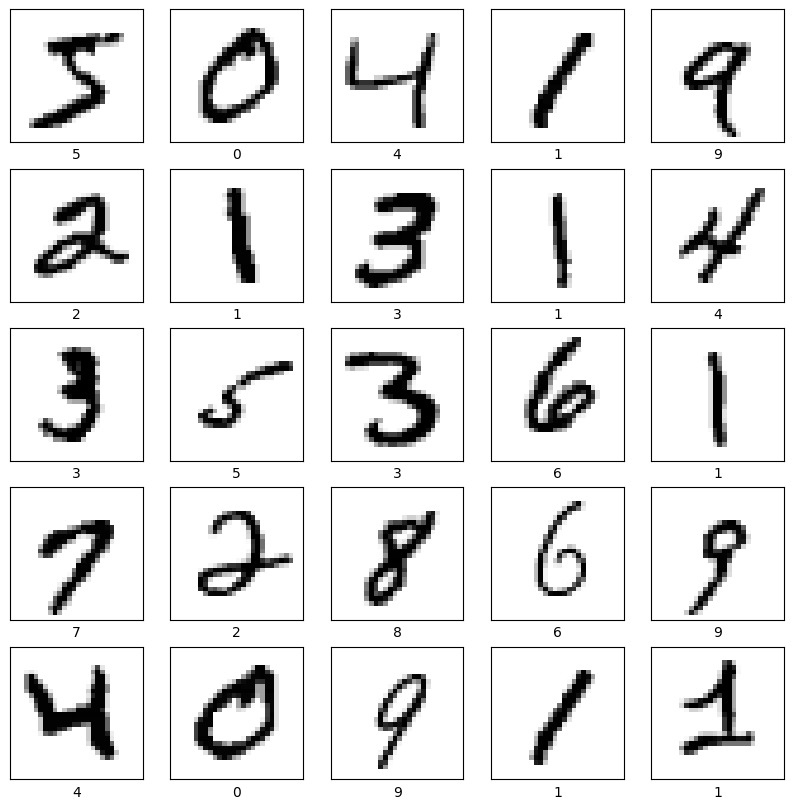

In [13]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## モデルの構築

ニューラルネットワークを構築するには、まずモデルのレイヤーを定義し、その後モデルをコンパイルします。

### ★レイヤーの設定

ニューラルネットワークの基本的な構成要素は、[*レイヤー*](https://www.tensorflow.org/api_docs/python/tf/keras/layers)です。レイヤーは、レイヤーに入力されたデータから表現を抽出します。 これらの表現は解決しようとする問題に有用であることが望まれます。

ディープラーニングモデルのほとんどは、単純なレイヤーの積み重ねで構成されています。`tf.keras.layers.Dense` のようなレイヤーのほとんどには、トレーニング中に学習されるパラメータが存在します。

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

このネットワークの最初のレイヤーは、`tf.keras.layers.Flatten` です。このレイヤーは、画像を（28 × 28 ピクセルの）2 次元配列から、28×28＝784 ピクセルの、1 次元配列に変換します。このレイヤーが、画像の中に積まれているピクセルの行を取り崩し、横に並べると考えてください。このレイヤーには学習すべきパラメータはなく、ただデータのフォーマット変換を行うだけです。

ピクセルが１次元化されたあと、ネットワークは 2 つの `tf.keras.layers.Dense` レイヤーとなります。これらのレイヤーは、密結合あるいは全結合されたニューロンのレイヤーとなります。最初の `Dense` レイヤーには、128 個のノード（あるはニューロン）があります。最後のレイヤーでもある 2 番めのレイヤーは、長さが 10 のロジット配列を返します。それぞれのノードは、今見ている画像が 10 個のクラスのひとつひとつに属する確率を出力します。

### モデルのコンパイル

モデルのトレーニングの準備が整う前に、さらにいくつかの設定が必要です。これらは、モデルの[*コンパイル*](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile)ステップ中に追加されます。

- [*損失関数*](https://www.tensorflow.org/api_docs/python/tf/keras/losses) —これは、トレーニング中のモデルの正解率を測定します。この関数を最小化して、モデルを正しい方向に「操縦」する必要があります。
- [*オプティマイザ*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) —これは、モデルが表示するデータとその損失関数に基づいてモデルが更新される方法です。
- [*指標*](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) —トレーニングとテストの手順を監視するために使用されます。次の例では、正しく分類された画像の率である正解率を使用しています。

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


## モデルの訓練

ニューラルネットワークモデルのトレーニングには、次の手順が必要です。

1. モデルトレーニング用データを投入します。この例では、トレーニングデータは `train_images` および <br>`train_labels` 配列にあります。
2. モデルは、画像とラベルの対応関係を学習します。
3. モデルにテスト用データセットの予測（分類）を行わせます。この例では `test_images` 配列です。その後、予測結果と `test_labels` 配列を照合します。
4. 予測が `test_labels` 配列のラベルと一致することを確認します。


### ★モデルに投入する

トレーニングを開始するには、[`model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) メソッドを呼び出します。

In [17]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.2623 - accuracy: 0.9246
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1176 - accuracy: 0.9657
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0807 - accuracy: 0.9755
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0604 - accuracy: 0.9809
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0471 - accuracy: 0.9851
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0357 - accuracy: 0.9892
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0286 - accuracy: 0.9908
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0230 - accuracy: 0.9929
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0195 - accuracy: 0.9941
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.015

モデルのトレーニングの進行とともに、損失値と正解率が表示されます。このモデルの場合、トレーニング用データでは 0.99 (すなわち 99%) の正解率に達します。

### 正解率を評価する

次に、モデルがテストデータセットでどのように機能するかを比較します。

In [18]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.0839 - accuracy: 0.9765 - 968ms/epoch - 3ms/step

Test accuracy: 0.9764999747276306


ご覧の通り、テスト用データセットでの正解率は、トレーニング用データセットでの正解率よりも少し低くなります。このトレーニング時の正解率とテスト時の正解率の差は、**過適合**の一例です。過適合とは、新しいデータに対する機械学習モデルの性能が、トレーニング時と比較して低下する現象です。過適合モデルは、トレーニングデータセットのノイズと詳細を「記憶」するため、新しいデータでのモデルのパフォーマンスに悪影響を及ぼします。詳細については、以下を参照してください。

- [過学習のデモ](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#demonstrate_overfitting)
- [過学習を防止するためのストラテジー](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#strategies_to_prevent_overfitting)

### 予測する

トレーニングされたモデルを使用して、いくつかの画像に関する予測を行うことができます。ソフトマックスレイヤーをアタッチして、モデルの線形出力である[ロジット](https://developers.google.com/machine-learning/glossary#logits)を解釈しやすい確率に変換します。

In [19]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [20]:
predictions = probability_model.predict(test_images)

313/313 [==============================] - 1s 2ms/step


これは、モデルがテスト用データセットの画像のひとつひとつを分類予測した結果です。最初の予測を見てみましょう。

In [21]:
predictions[0]

array([3.5560617e-11, 2.1919317e-09, 2.7215275e-08, 7.8640896e-06,
       1.4001514e-14, 3.0348859e-11, 4.0989072e-15, 9.9999195e-01,
       1.1724600e-09, 7.7234809e-08], dtype=float32)

予測結果は、10個の数字の配列です。これは、その画像が10の衣料品の種類のそれぞれに該当するかの「確信度」を表しています。どのラベルが一番確信度が高いかを見てみましょう。

In [22]:
np.argmax(predictions[0])

7

このモデルは、この画像が、`7`である可能性が最も高いと判断したことになります。これが正しいかどうか、テスト用ラベルを見てみましょう。

In [23]:
test_labels[0]

7

これをグラフ化して、10 クラスの予測の完全なセットを確認します。

In [24]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### ★予測を検証する

トレーニングされたモデルを使用して、いくつかの画像に関する予測を行うことができます。

0 番目の画像、予測、および予測配列を見てみましょう。 正しい予測ラベルは青で、間違った予測ラベルは赤です。 数値は、予測されたラベルのパーセンテージ (/100) を示します。

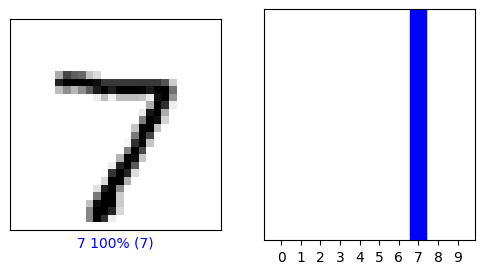

In [25]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

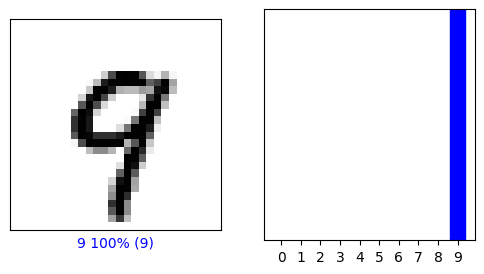

In [26]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

いくつかの画像をそれらの予測とともにプロットしてみましょう。確信度が高い場合でも、モデルが間違っていることがあることに注意してください。

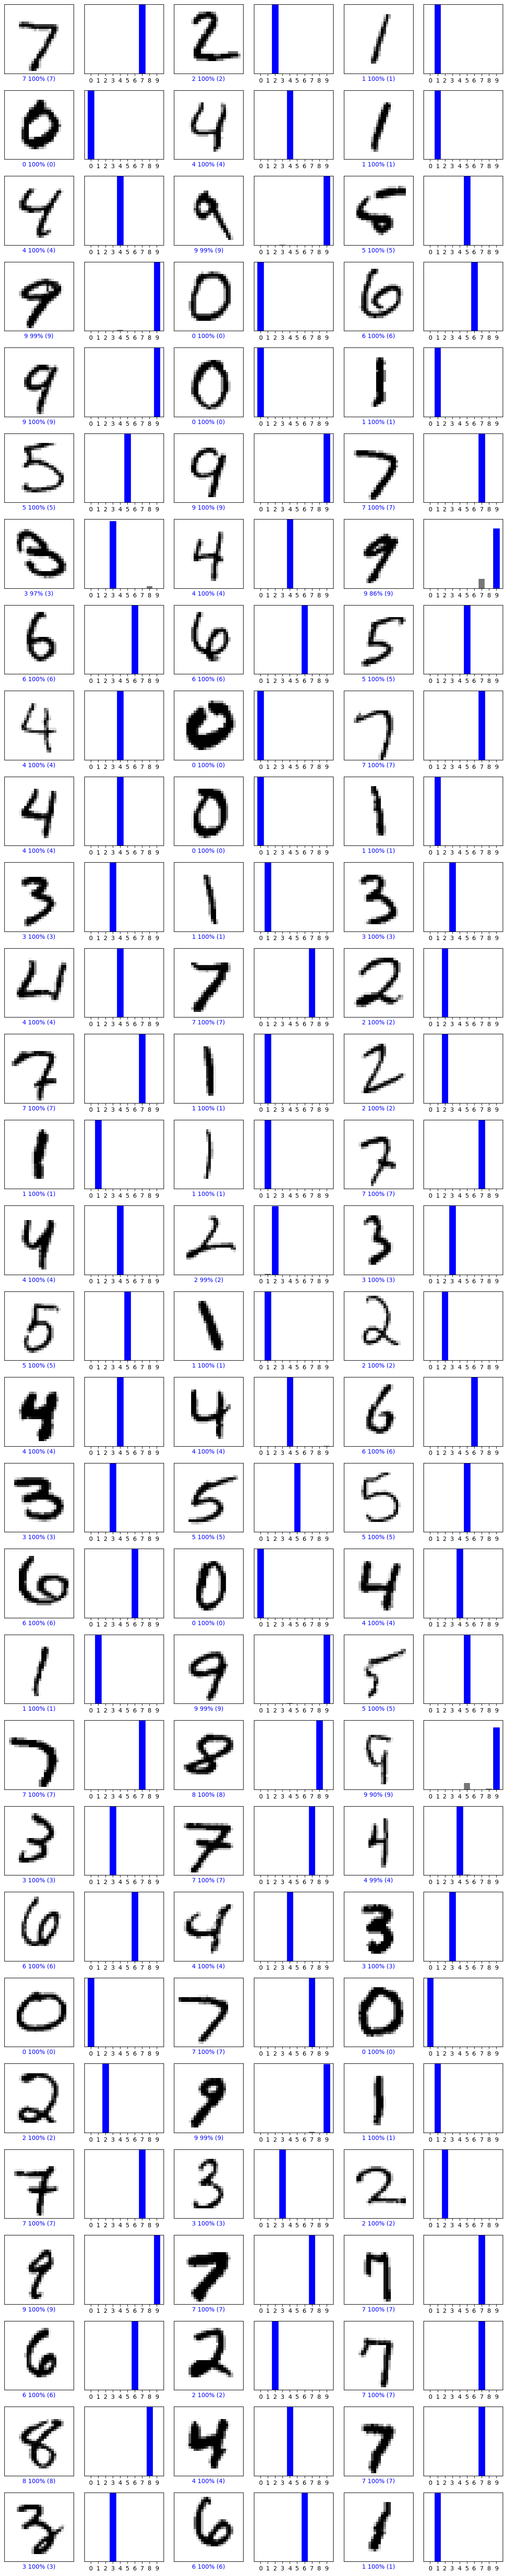

In [27]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 30
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## トレーニングされたモデルを使用する

最後に、トレーニング済みモデルを使って 1 つの画像に対する予測を行います。

In [28]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(28, 28)


`tf.keras` モデルは、サンプルの中のバッチあるいは「集まり」についてまとめて予測を行うように最適化されています。そのため、1 つの画像を使う場合でも、リスト化する必要があります。

In [29]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


そして、予測を行います。

In [30]:
predictions_single = probability_model.predict(img)

print(predictions_single)

1/1 [==============================] - 0s 22ms/step
[[8.2645651e-10 1.6989474e-10 9.9999988e-01 1.8379358e-10 7.9758033e-22
  1.4870972e-07 5.1673371e-10 1.6704694e-20 3.3372364e-11 1.1428948e-14]]


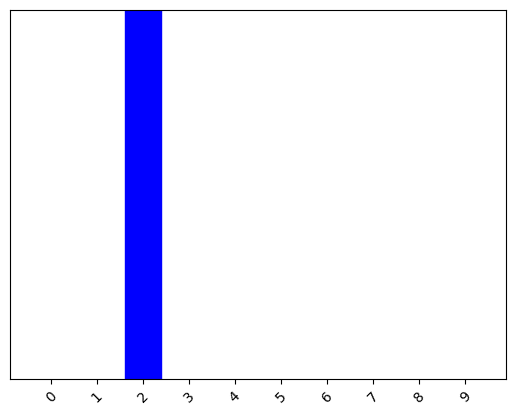

In [31]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()

`tf.keras.Model.predict` は、リストのリストを返します。リストの要素のそれぞれが、バッチの中の画像に対応します。バッチの中から、(といってもバッチの中身は１つだけですが) 予測を取り出します。

In [32]:
np.argmax(predictions_single[0])

2

モデルは期待どおりにラベルを予測しました。